## Numerical Linear Algebra Coursework
Module: MA50178

## Q1 / Preamble Code

Code and Markdown comments are copied from Q1 of MA50178 coursework (cw). The code has been split into code cells as it appears in the cw document and numbered in order. Documented findings can be found at the end of the question.

In [2]:
#1.1 imports
from sklearn.datasets import fetch_openml
from skimage.transform import radon
import numpy as np
import matplotlib.pyplot as plt

We start by loading a set of images $x_i \in R^n$

In [3]:
#1.2 Data Loading
X, y = fetch_openml("mnist_784", version=1, return_X_y=True,
                    as_frame=False, parser="pandas")
X = X.astype('double')

Here and below, please familiarise yourself with all objects, e.g., via X.shape. They can also be visualised either as vectors or reshaped as images. The latter is usually more useful and can be done with the following code.

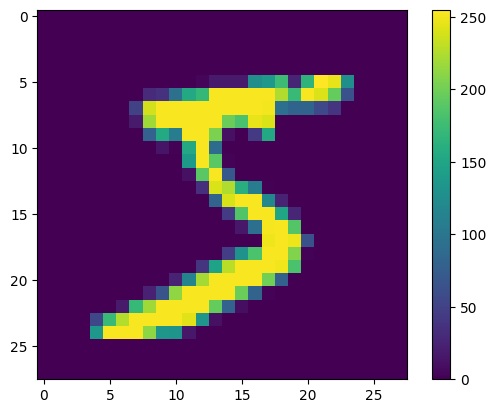

In [4]:
#1.3 Image Generation
imsize = (28, 28)


def show_image(x):
    plt.imshow(np.reshape(x, imsize))
    plt.colorbar()


show_image(X[0])

We then construct the matrix R which represents our imaging system and create a data set f (this would usually be measured by a scanner, e.g., at a hospital). To this end, we first define the function trans which models the physics.

/Library/Python/3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


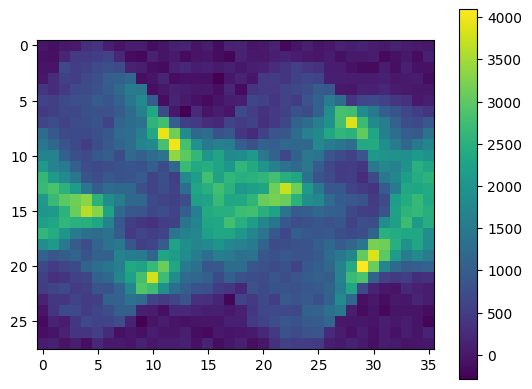

In [5]:
#1.4 trans function
theta = range(0, 359, 10)


def trans(x):
    return radon(np.reshape(x, imsize), theta)


f = trans(X[0])
f += 100 * np.random.standard_normal(f.shape)
plt.imshow(f)
plt.colorbar()

The effect of this function can be best visualised by its action on a standard normal vector, or in imaging-speak, a point-source.


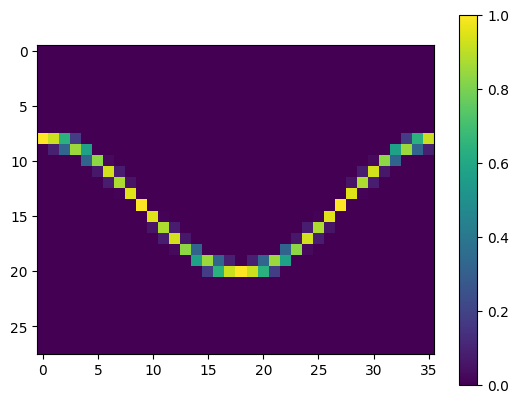

In [6]:
#1.5 Visualising effect of trans
n = np.prod(imsize)
e = np.zeros(n)
e[400] = 1
show_image(e)
Re = trans(e)
plt.imshow(Re)

Now we are in a position to compute R.

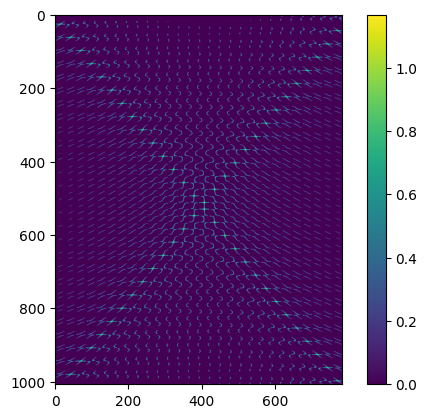

In [7]:
#1.6 Computing R
m = Re.size
e = np.zeros(n)
R = np.zeros((m, n))
for i in range(len(e)):
    e[i] = 1
    R[:, i] = trans(e).ravel()
    e[i] = 0
plt.imshow(R)
plt.colorbar()

As discussed in the lecture, we will try to solve $Rx=f$ via $Ax=b$ with $A=R^TR$ and$b=R^Tf$.

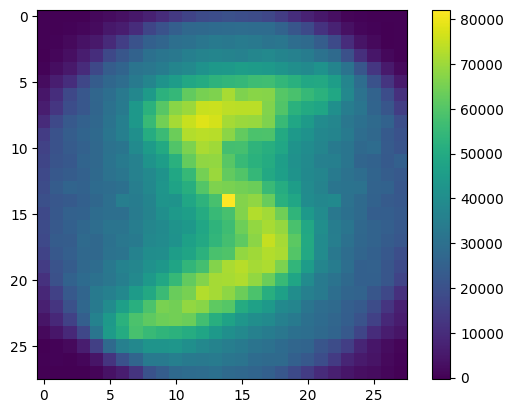

In [8]:
#1.7 Solving
A = R.T @ R
b = R.T @ f.ravel()
show_image(b)

It turns out that an inversion of this system directly does not work well.

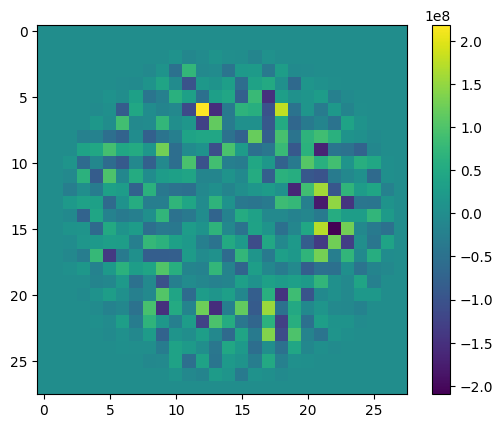

In [9]:
#1.8 Inversion attempt at solving:
xb = np.linalg.solve(A, b)
show_image(xb)

If we instead solve a “regularised” system $A_\alpha x = b$ with $A_\alpha = A + \alpha I$, we recover our ground truth image $x$ well.

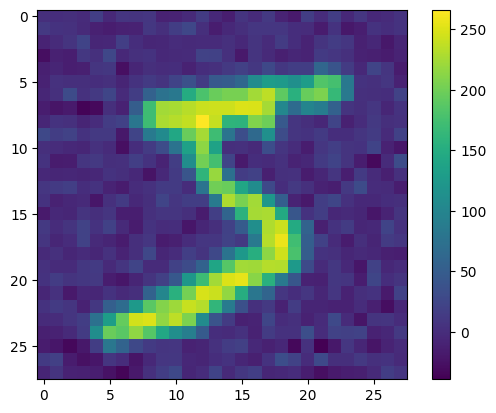

In [10]:
#1.9 Attempt 2 (regularised system):
Aalpha = A + 10 * np.eye(784)
xalpha = np.linalg.solve(Aalpha, b)
show_image(xalpha)

## Q1 Documented Findings
Code blocks 1.1-1.3: THis loads the MNist-784 dataset, a dataset containing 70,000 samples of hand drawn digits (0-9) stored as 28*28 pixel images with each pixel assigned a value between 0 and 255, this is likely a value denoting the presence of 'ink' or similar on a blank surface. This is stored as an array X with X[0] being an image of a hand drawn 5.

Code blocks 1.4-1.5: These introduce the trans function, effectively a wrapper for the radon function which takes an image and returns its sinogram (a set of projections of the image into a single dimension by cutting rays at different angles across the image). 1.5 then shows an example of this.

Code blocks 1.6-1.7: This creates the $R$ matrix as setup for our linear algebra problem by operating the trans function on each pixel of the X[0] image one at a time. R then becomes a (1008,784) matrix where 784 comes from the image size ($28^2$) and 1008 is the number of datapoints created from the trans function for a single image. $A = R^T \times R$ and $b = R \times f$ are then generated ($f$ has been 'flattened' here to allow for matrix multiplication).

Code block 1.8: Here an attempt is made to solve the system using np.linalg.solve(). The noise added causes issues for the solver and creates a very noisy 'solution'.

Code block 1.9: Another attempt is made to solve the system here, this time using $A_\alpha = A + 10I$. This is called regularisation and provides multiple advantages.
Firstly, $\sigma(A_\alpha) = \sigma(A) + 10$ i.e. $\lambda_{\alpha,i} = \lambda_{A,i} + 10 \quad \forall \lambda_{A,i} \in \sigma(A)$. This reduces the sensitivity of the system with respect to small changes in the initial data as $\lambda_{max}/\lambda_{min}\approx 1$. This is helpful as $||A_{\alpha}|| \approx ||A_{\alpha}^{-1}||$ so the inverse won't be badly affected by noise in the system.
Secondly, the regularisation penalises solutions where large components come from directions associated with small eigenvalues of the system (i.e. the solver favours larger eigenvalues for constructing the solution).

## Q2 Implementation of G-S
Here there are three versions of the G-S method. These are the implementations of questions 2i, 2ii and 2iv.
Note: I appreciate that coding a singular function with an arguement to select version i,ii,iv would look neater however for fairness when timing the functions I have written three versions of the similar function.

 ### 2i.

In [11]:
def GSSolve_i(A, b, x_0, tol=10 ** (-15), max_iters=10 ** 6):
    res = 1  #sets res = 1 to trigger while loop
    size = np.size(b)  #obtains dimension of x,b
    x_old = x_0  #initialises x_old. This will store the equivalent of x^k in the lecture notes algorithm
    x_new = np.zeros(size)  #initialises x_new. This will store the equivalent of x^(k+1)
    k = 0  #k stores the number of iterations performed
    while (res > tol) and (k < max_iters):  #Iterates the GS method until either res < tol or max_iters is met.
        for i in range(0, size):  #iterates through x_i values
            sum = b[i]
            for j in range(0, size):
                if j < i:
                    sum -= A[i, j] * x_new[j]
                elif j > i:
                    sum -= A[i, j] * x_old[j]
            x_new[i] = sum / A[i, i]
        res = np.linalg.norm(b - A @ x_new)
        k += 1
        x_old[:] = x_new
    return (x_new, k)

### 2ii.

In [12]:
def GSSolve_ii(A, b, x_0, tol=10 ** (-15), max_iters=10 ** 6):
    res = 1
    size = np.size(b)
    x_old = x_0
    x_new = np.zeros(size)
    k = 0
    while (res > tol) and (k < max_iters):
        for i in range(0, size):
            sum = b[i]
            for j in range(0, size):
                if j < i:
                    sum -= A[i, j] * x_new[j]
                elif j > i:
                    sum -= A[i, j] * x_old[j]
            x_new[i] = sum / A[i, i]
        res = np.linalg.norm(x_new - x_old, ord=np.inf) / np.linalg.norm(x_old, ord=np.inf)
        k += 1
        x_old[:] = x_new
    return (x_new, k)

### 2iv.

In [13]:
def GSSolve_iv(A, b, x_0, tol=10 ** (-15), max_iters=10 ** 6):
    res = 1
    size = np.size(b)
    x_old = x_0
    x_new = np.zeros(size)
    k = 0
    while (res > tol) and (k < max_iters):
        for i in range(0, size):
            tmp = b[i] - np.dot(A[i, :i], x_new[:i]) - np.dot(A[i, i + 1:], x_old[i + 1:])
            x_new[i] = tmp / A[i, i]
        res = np.linalg.norm(x_new - x_old, ord=np.inf) / np.linalg.norm(x_old, ord=np.inf)
        k += 1
        x_old[:] = x_new
    return (x_new, k)

### 2iii.
We now use the time package to time each version.

In [14]:
from time import time

x_0 = np.ones(np.shape(b))
max_iters = 100


def timeTest(solver):
    t = time()
    sol = solver(Aalpha, b, x_0=x_0, max_iters=max_iters)
    t_ = time()
    print('iters: ', sol[1])
    return (t_ - t)


print('GSi:')
print(timeTest(GSSolve_i))
print('GSii:')
print(timeTest(GSSolve_ii))
print('GSiv:')
print(timeTest(GSSolve_iv))

GSi:
iters:  100
16.211328983306885
GSii:
iters:  100
11.140508890151978
GSiv:
iters:  100
0.1255507469177246


## Q2 Documented Findings
Here we denote $T_k$ as the time for 100 iterations to run of the question k variant of the GS algorithm (i.e. $T_i$ is the time for the algorithm in Q2i.

Here we see that the main iteration loop found in GSi and GSii runs fairly inefficiently and leads to $T_i,T_{ii}>10s$ for 100 iterations. (Note this time may be different when run on different computers). The optimised version of this loop, which makes use of np.dot(), runs approximately 10^2 times more quickly. This suggests than np.dot is vastly more efficient than python for loops (which is to be expected).

The change in residual calculation from GSi to GSii provides a decrease in runtime by approximately 40%. When run locally this is seen as $T_i=16.3s$ and $T_{ii}=10.4s$.


When testing in Q2iii iters is printed (but only outside the timing loop due to the inefficiency of the print function) to see whether an implementation has converged early. This is because there could exist an algorithm that converges in $<100$ iterations but each iteration take a longer amount of time. Forcing this algorithm to run for exactly 100 iterations would unfairly bias the timing.

A tolerance of $10^{-15}$ is chosen as this is approximately the size of a double in C for numbers near to 0.

## 2v.

Here we aim to show that the Gauss-Seidel method for this problem will converge $\forall \alpha >0$. We start by noting that Theorem 2.31 tells us that the GS method will converge for any starting value $x^{(0)}\in\mathbb{R}^n$ if $A_\alpha\in\mathbb{R}^{n\times n}$ is SPD. Therefore, it suffices to show that $A_\alpha$ is SPD $\forall \alpha >0$.

As $A = R^TR$ we have that $A$ is symmetric. Therefore, $A_\alpha = A + \alpha I$ is also symmetric.

We now need to show that $A_\alpha$ is positive definite, i.e. $x^TA_\alpha x > 0 \quad \forall x\in\mathbb R^n \backslash\{\underline 0\}$.

We have:
$x^TA_\alpha x = x^T(A+\alpha I)x$
$\qquad = x^TAx x^T(\alpha I)x$
$\qquad = x^TAx + \alpha x^Tx$
$\qquad = x^TAx + \alpha ||x||_2^2$

Noting that $\alpha||x||_2^2 > 0 \quad \forall x\in\mathbb R^n \backslash\{\underline 0\}$ as $\alpha>0$. We now use that $A = R^TR$:

$x^TA_\alpha x = x^TR^TRx + \alpha ||x||_2^2$
$\qquad = (Rx)^T(Rx) + \alpha ||x||_2^2$
$\qquad = ||Rx||_2^2 + \alpha ||x||_2^2$

Where both terms are norms and therefore $>0 \quad \forall x\neq\underline0$.

Therefore $x^TA_\alpha x > 0$ so $A_\alpha is SPD$.

This gives us that the GS method will converge for $A_\alpha$ $\forall \alpha > 0$.
$\square$

# Q3: A fast implementation of Jacobi

### 3i.

We implement a version of the Jacobi method along the lines of the function in Q2iv

In [15]:
def JacobiSolve(A, b, x_0, tol=10 ** (-15), max_iters=10 ** 6):
    res = 1
    size = np.size(b)
    x_old = x_0
    x_new = np.zeros(size)
    k = 0
    while (res > tol) and (k < max_iters):
        for i in range(0, size):
            tmp = (b[i] - np.dot(A[i, :], x_old[:]))
            x_new[i] = x_old[i] + (tmp / A[i, i])
        res = np.linalg.norm(x_new - x_old, ord=np.inf) / np.linalg.norm(x_old, ord=np.inf)
        k += 1
        x_old[:] = x_new
    return (x_new, k)

We now run timeTest() to investigate the efficiency of the solver

In [16]:
timeTest(JacobiSolve)

iters:  100


0.08820986747741699

### 3ii.

Here we will show that $\exists \alpha > 0$ such that the Jacobi method converges for $A_\alpha$. By Theorem 2.30 we need only show that $2D-A_\alpha$ is SPD. $D = diag(A_\alpha)$ is defined as the matrix containing only the diagonal elements of $A_\alpha$. By the previous question we have that $A_\alpha$ and therefore $-A_\alpha$ are symmetric. By adding only diagonal elements we have that $2D - A_\alpha$ is symmetric.

As $2D - A_\alpha$ is symmetric $\exists P \in O(n)$ such that $Q = P^{-1}(2D - A_\alpha)P$ is diagonal and $\sigma(Q) = \sigma(2D - A_\alpha)$ where the diagonal elements of $Q$ are precisely the eigenvalues of $A_\alpha$.

By defining $D' = diag(A)$ we have $D = D' + \alpha I$ and therefore $Q = P^{-1}(2(D' +\alpha I) - A - \alpha I)P = P^{-1}(2D'-A)P + P^{-1}\alpha I P$.
This gives us $Q = \alpha I + Q'$ where $Q' = P^{-1}(2D'-A)P$ and $\sigma(Q') = \sigma(2D'-A)$.
We now have that $\forall \lambda\in\sigma(Q) \exists \lambda'\in\sigma(Q')$ such that $\lambda = \lambda' + \alpha$. i.e. the spectrum of $Q$ is the spectrum of $Q'$ shifted by $+\alpha$.

Specifically, $\lambda_{min} = \min_{\lambda \in \sigma(Q)}\lambda$ is $\lambda_{min} = \alpha + \lambda'_{min}$ where $\lambda'_{min} =\min_{\lambda' \in \sigma(Q')}\lambda'$.

Therefore choosing $\alpha > |\lambda'_{min}|$ gives $\lambda_{min} > 0$. Therefore $Q$ is positive definite and also $2D-A_\alpha$ is positive definite.

We now have $2D-A_\alpha$ is SPD and therefore $\exists \alpha > 0$ such that the Jacobi method for $A_\alpha$ converges $\forall x \in \mathbb R^n$.
$\square$

# Q4 Finding a good regularisation parameter
### 4i - 4iii

In [17]:
#defining GaussSeidel wrapper function to call GSSolve_iv in the specified format as per q4i.
def GaussSeidel(A, b, niter=1000, tol=1e-2):
    x_0 = np.ones(np.shape(b))
    return GSSolve_iv(A, b, x_0=x_0, max_iters=niter, tol=tol)[0]


#Now define lambda function: recon
recon = lambda alpha: GaussSeidel(A + alpha * np.eye(np.shape(A)[0]), b)


#We define a function that returns an array of the mean termination time and mean reconstruction quality for each value of alpha in the inputted list of alphas
def getRecon(alphas, iterations):
    terminateTime = np.zeros(np.size(alphas))  #initialising array
    reconstructionQuality = np.zeros(np.size(alphas))  #initialising array
    for j in range(iterations):  #iterating the process in q4ii multiple times to take a mean
        for i in range(len(alphas)):  #iterating over alpha values
            t = time()  #starting timing
            reconVal = recon(alphas[i])  #calling recon(alpha)
            t_ = time()  #ending timing
            terminateTime[i] += (t_ - t) / iterations  #appending contribution to mean of termination time
            reconstructionQuality[i] += (np.linalg.norm(reconVal - X[0]) ** 2 / np.linalg.norm(
                X[0]) ** 2) / iterations  #appending to contribution to mean of reconstruction quality
    return terminateTime, reconstructionQuality

We now call getRecon() to visually analyse the behaviour of the termination time and reconstruction quality

In [18]:
#Iterate over range of alpha values
alphas = np.logspace(-1, 3, 10)
# calling getRecon
terminateTime, reconstructionQuality = getRecon(alphas, iterations=10)

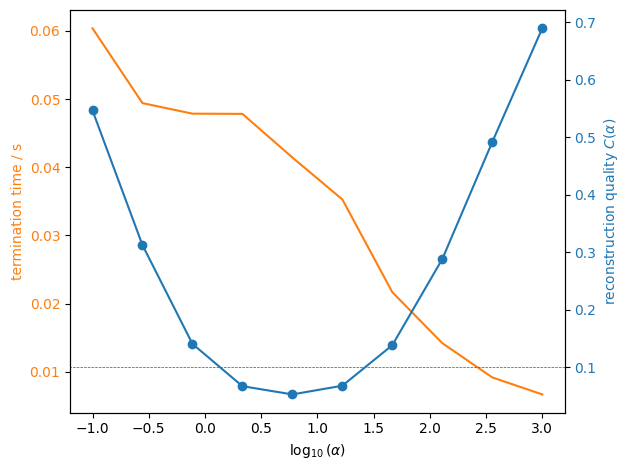

In [19]:
#Plotting the means of reconstruction quality and termination time against alpha values for visual investigation
def comparisonPlot(alphas, terminateTime, reconstructionQuality):
    fig, ax1 = plt.subplots()

    color = 'tab:orange'
    ax1.set_xlabel(r'$\log_{10}(\alpha)$')
    ax1.set_ylabel('termination time / s', color=color)
    ax1.plot(np.log10(alphas), terminateTime, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(r'reconstruction quality $C(\alpha)$', color=color)
    ax2.plot(np.log10(alphas), reconstructionQuality,
             color=color)  #plotting the line to show the general behaviour of reconstructionQuality
    ax2.scatter(np.log10(alphas), reconstructionQuality,
                color=color)  #highlighting individual points for visual analysis
    ax2.axhline(y=0.1, xmin=-1, xmax=3, c='red', linestyle='--', linewidth=0.5,
                zorder=0)  #including a horizontal line at C(\alpha) = 0.1 to identify points below this value
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


comparisonPlot(alphas, terminateTime, reconstructionQuality)

Here we can identify that $10^0<\alpha<10^{1.5}$ generally gives $C(\alpha) < 0.1$ as required. We also identify that the termination time of the process is monotonically decreasing suggesting that the largest $\alpha$ satisfying $C(\alpha) < 0.1$ will provide the shortest termination time.
Below we iterate over more values of $\alpha \in (10^0,10^{1.75})$

In [20]:
alphas = np.logspace(0, 1.75, 40)  #testing a higher resolution of alpha values
bestAlpha = alphas[0]
bestIndex = 0
terminateTime, reconstructionQuality = getRecon(alphas, 20)

for index, alpha in enumerate(alphas):
    if (terminateTime[index] < terminateTime[bestIndex]) and (reconstructionQuality[index] < 0.1):
        bestIndex, bestAlpha = index, alpha

print(np.log10(bestAlpha), bestIndex, terminateTime[bestIndex])

1.4807692307692308 33 0.026376366615295407


We now plot using the same code as previously.

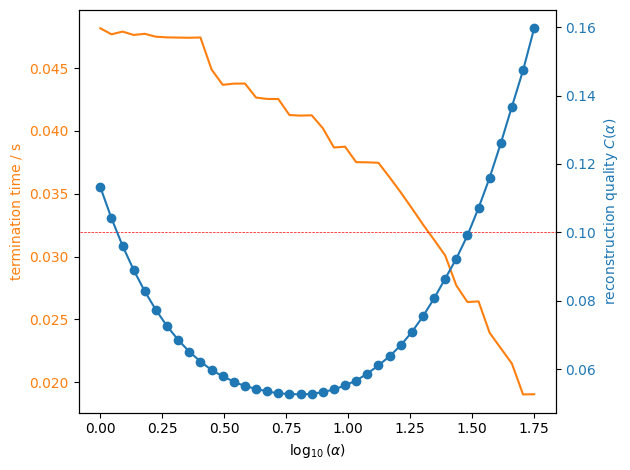

In [21]:
comparisonPlot(alphas, terminateTime, reconstructionQuality)

Here we can see that the termination time does not monotonically decrease $\forall \alpha$ but generally does for $\alpha > 10^{1.25}$. We therefore take $\alpha = 10^{1.48}$ as our 'good value' of $\alpha$ to minimise the time taken for the Gauss Seidel method to terminate. The time taken is $t=0.027s \quad (2sf)$.

# Q5 Further algorithms for image reconstruction

We now implement a version of the Kaczmarz algorithm to solve the same $Ax=b$ problem as previously.
### 5i.

In [35]:
def Kaczmarz(A, b, tol=1e-8, niters=100):
    res, k = 1, 0  #assigning iteration variables
    size = np.size(b)  #obtaining dimension of x
    resList = np.zeros(niters)  #keeping track of residuals
    x = np.zeros(size)  #setting x^(0)
    x_temp = np.zeros((size, size + 1))  #initialising x^(k+1,i) matrix
    while (res > tol) and k < niters:  #iterating until niters is met or res < tol.
        x_temp[:, 0] = x
        for i in range(1, size + 1):
            j = np.random.randint(0, size)
            tmp = (b[j] - np.dot(A[j], x_temp[:, i - 1])) / np.dot(A[j], A[j])
            x_temp[:, i] = x_temp[:, i - 1] + tmp * A[j].T
        res = np.linalg.norm(A @ x_temp[:, size] - b) ** 2 / np.dot(b, b)
        resList[k] = res
        k += 1
        x[:] = x_temp[:, size]
    return (x, resList)

In [36]:
#redefining GS method to work with new residual
def GaussSeidel(A, b, tol=1e-8, niters=100):
    res, k = 1, 0
    size = np.size(b)
    resList = np.zeros(niters)
    x_old = np.zeros(size)
    x_new = np.zeros(size)
    while (res > tol) and (k < niters):
        for i in range(0, size):
            tmp = b[i] - np.dot(A[i, :i], x_new[:i]) - np.dot(A[i, i + 1:], x_old[i + 1:])
            x_new[i] = tmp / A[i, i]
        res = np.linalg.norm(A @ x_new - b) ** 2 / np.dot(b, b)
        resList[k] = res
        k += 1
        x_old[:] = x_new
    return (x_new, resList)

We now plot the residuals of these methods:

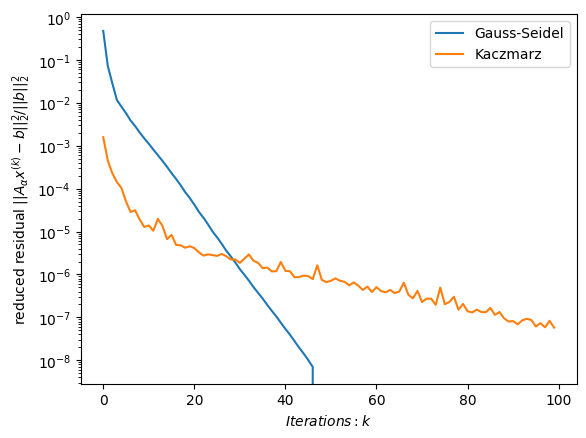

In [44]:
kList = np.array([k for k in range(100)])

KzList = Kaczmarz(Aalpha, b)[1]
GSList = GaussSeidel(Aalpha, b)[1]

plt.semilogy(kList, GSList, label='Gauss-Seidel')
plt.semilogy(kList, KzList, label='Kaczmarz')
plt.legend()
plt.xlabel(r'$Iterations: k$')
plt.ylabel(r'reduced residual $||A_\alpha x^{(k)} - b||_2^2 / ||b||_2^2$')
plt.show()

Here we can see that the Gauss Seidel method reaches the tolerance around the 45th iteration whereas the Kaczmarz method does not reach the tolerance after 100 iterations. When experimenting with larger numbers of iterations and stricter tolerances the GS method continues to converge more quickly than the Kaczmarz method does.

# 5iii
The Kaczmarz method may be favourable to the GS method when A is large or the system is overdetermined. GS is defined to work with a square matrix whereas the Kaczmarz method in this formulation does not necessarily require this. Only that the number of columns of A matches the size of x.

When the system is large the Kaczmarz method only requires knowledge of one row of A at a time whereas the GS method requires entire columns.

# Q6 Over-determined systems

### 6i
We have the system $y=Ax+\eta$ where $A\in\mathbb R^{m\times n}, y\in\mathbb R^m, x\in\mathbb R^n$.
We wish to find $x^*\in\mathbb R^n$ such that:
$||Ax-y||_2 \geq ||Ax^* - y||_2\qquad \forall \quad x\in\mathbb R^n \qquad \qquad (2)$.
Given the columns of $A$, $\{a_1,\ldots,x_n\}$ are linearly independent. We first want to show that a unique solution to (2) is:
$x^* := (A^T A)^{-1}A^Ty$

To do this we first show $(A^T A)^{-1}$. That is $A^TA$ has an inverse which occurs iff $\det A^TA \neq 0$.

We can observe that $A^T A$ is symmetric and by considering $x^TA^TAx$ for $x\in\mathbb R^n$ we have:

$x^TA^TAx = |Ax|_2^2 > 0 \quad \forall \quad x\in\mathbb R^n\backslash\{\underline 0\}$.

We note here that linear independence gives us the strict inequality above as without linear independence we could have $Ax = 0$ for some $x\neq0$. With linear independence of the columns of A we have that $Ax = 0 \iff x=0$.

Therefore, we have that $A^TA$ is SPD and from this $\det A^TA > 0$.

As we now know that $(A^TA)^{-1}$ exists we can see that:

$||Ax^* - y||_2 = ||A(A^T A)^{-1}A^Ty - y||_2 = ||A A^{-1} \left(A^T\right)^{-1}A^Ty - y||_2 = ||I\times Iy - y||_2 = ||y-y||_2 = 0$

By the property of norms. $||x|| \geq 0 \quad \forall x\in\mathbb R^n$.

Therefore $x^*$ is a solution of (2).

To show uniqueness we now consider another solution $\tilde x \neq x^*$. By (2) we have both:

$||A\tilde x-y||_2 \geq ||Ax^* - y||_2$
$||Ax^*-y||_2 \geq ||A\tilde x - y||_2$

Which gives $||Ax^*-y||_2 \geq ||A \tilde x-y||_2 \geq ||Ax^*-y||_2 \implies ||A\tilde x - y||_2 = ||Ax^* - y||_2 = 0$.

As $||x|| = 0 \iff x=0$ we have $A\tilde x - y = 0 = Ax^* - y$ which gives us that $A\tilde x = Ax^*$.

As the columns of A are linearly independent we have a unique solution to the equation $A(\tilde x - x^*) = 0$ specifically $\tilde x - x^* = 0$ which gives us $\tilde x = x^*$ contradicting our assumption of two differing solutions.

Therefore, $x^*$ is a unique solution to (2).

### 6ii

Given $U\Sigma V^T = A$ is the SVD factorisation of A where $\Sigma = (\hat\Sigma \quad 0)^T \in \mathbb R^{m\times n}$ and $\hat\Sigma =$diag$(\sigma_1,\ldots,\sigma_n) \in \mathbb R^{n\times n}$, with $\sigma_1\geq\ldots\geq\sigma_n\geq0$.

We want to show that $\det \hat\Sigma \neq 0$ and

$x^* = V\Sigma^+U^Ty$, where $\Sigma^+ := \left(\hat\Sigma^{-1}\quad 0\right) \in \mathbb R^{n\times m}$.

To start we use that $\sigma_i = \sqrt{\lambda_i}$ where $\lambda_i\in\sigma(A^TA)$ and $\lambda_1 \geq \lambda_2 \geq \ldots \geq\lambda_n\geq0$.
From 6i we have that $A^TA$ is SPD and therefore $\lambda_n > 0$ which gives us that $\sigma_n > 0$.

We have that $\det \hat\Sigma = \prod_i \sigma_i \geq \sigma_n^n > 0$ as required.


For the second part we start with the definition of $x^*$:

$x^* = (A^TA)^{-1}A^Ty$

and replace A with its SVD:

$x^* = ((U\Sigma V^T)^T (U\Sigma V^T))^{-1} (U\Sigma V^T)^Ty$

and use $(ABC)^T = C^TB^TA^T$ to get:

$x^* = ((V\Sigma^T U^T) (U\Sigma V^T))^{-1} (V\Sigma^T U^T)y$

We now use that $U^-1 = U^T$ as $U$ is orthogonal:

$x^* = (V\Sigma^T U^{-1} U\Sigma V^T)^{-1} (V\Sigma^T U^T)y$

and by $U^{-1} U = I$

$x^* = (V\Sigma^T \Sigma V^T)^{-1} (V\Sigma^T U^T)y$

Now using that for $A,B,C \in \mathbb R^{n\times n}$:
$(ABC)^{-1} = C^{-1}B^{-1}A^{-1}$

$x^* = V^{-T}(\Sigma^T \Sigma)^{-1}V^{-1} (V\Sigma^T U^T)y$

Here we use the shorthand $V^{-T} = (V^T)^{-1}$.

Now using that as $V$ is orthogonal so $V^T = V^{-1}$:

$x^* = V(\Sigma^T \Sigma)^{-1}\Sigma^T U^Ty$

We now focus on the object:

$(\Sigma^T \Sigma)^{-1}\Sigma^T$

First considering $\Sigma^T \Sigma$ we have:

$(\hat \Sigma \quad 0) (\hat \Sigma \quad 0)^T = (\hat \Sigma)^2$

and using $(A^2)^{-1} = (A^{-1})^2 $ for $A$ as a square matrix and that $\hat \Sigma$ is invertible as $\det \hat \Sigma > 0$.

We therefore have:

$(\Sigma^T \Sigma)^{-1}\Sigma^T = ((\hat \Sigma)^{-1})^2\Sigma^T$

Observing $(\hat \Sigma)^{-1}\Sigma^T = (I \quad 0)$ we finally have:

$(\Sigma^T \Sigma)^{-1}\Sigma^T = (\hat \Sigma^{-1} \quad 0) = \Sigma^+$ as defined in the question.

Therefore going back to $x^*$:

$x^* = V\Sigma^+ U^T y$ as required.


### 6iii

If x is the solution to $Ax+\eta = y$ find an upper bound for $||x-x^*||_2$:

Considering first, $x^* = (A^TA)^{-1}A^Ty$ and replacing $y = Ax + \eta$ we get:

$x^* = (A^TA)^{-1}A^T(Ax + \eta)$ which when rearranged and simplified gives:

$x^*-x = (A^TA)^{-1}A^T\eta$

We note that from the previous questions we have $(A^TA)^{-1}A^T = V\Sigma^+U^T$. Applying this and taking the 2-norm of both sides yields:

$||x^* - x||_2 = ||V\Sigma^+U^T\eta||_2$

From the NLA course we have that $||ABx||_2 \leq ||A||_2||B||_2||x||_2$ giving us:

 $||x - x^*||_2 = ||V||_2||\Sigma^+||_2||U^T||_2||\eta||_2$

And noting $||U||_2 = ||V||_2 = 1$ as $U,V$ are orthogonal matrices we have:

$||x - x^*||_2 = ||\Sigma^+||_2||\eta||_2$      (3)

From Golub and van Loan 2nd Edn p.72 we have:

$||\Sigma^+||_2 =1 / \sigma_n$      (4)

 Now turning our attention to the $||\eta||_2$ we take from earlier that:

$||Ax^*-y||_2 = 0$

Replacing $y=Ax+\eta$ we get:

$||A(x^*-x)-\eta||_2 = 0$

and using the property of norms we have that:

$||A(x^*-x)||_2 = ||\eta||_2$

Combining with (3) and (4) we have:

$||x-x^*||_2 \leq ||A(x^*-x)||_2/\sigma_n$

as required :) $\square$

From (2) we have: $||\eta||_2 \geq ||A(x^*-x)-\eta||_2$.
When $\sigma_n \ll 1$ we would require a large change in x to sustain the inequality.

# 6iv
We now introduce the inequality:

$||Ax-y||_2^2 + \alpha||x||_2^2 \geq ||A\hat x-y||_2^2 + \alpha||\hat x||_2^2$

and aim to show it has a unique solution.

We first find a solution $\hat x$.

Attempting to minimise $||Ax-y||_2^2 + \alpha||x||_2^2$ we write it as:

$(Ax-y)^T(Ax-y) + \alpha x^Tx = x^TA^TAx - y^TAx - x^TA^Ty + y^Ty + \alpha x^Tx$

Noting that all terms here are scalars we have $y^TAx = x^TA^Ty$ giving us:

$||Ax-y||_2^2 + \alpha||x||_2^2 = x^TA^TAx - 2y^TAx + y^Ty + \alpha x^Tx$.

We can rewrite the RHS as x^T(A^T A + \alpha I)x - 2y^TAx

Taking the gradient with respect to $x$ and setting this equal to zero we have:

$2(A^T A + \alpha I)x - 2A^Ty = 0$ (*)

Where we have used that $\nabla x^TBx = 2Bx$ for a symmetric matrix B (which in our case $B=(A^T A + \alpha I)$ and is indeed symmetric.

This can best be seen using einstein summation convention:

$\partial_i x_jB_{jk}x_k = \delta_{ij}B_{jk}x_k + x_iB_{jk}\delta_{ik} = B_{ik}x_k + B_{ij}x_j$

As B is symmetric $B_{ij} = B_{ji}$ giving us:

$\partial_i x_jB_{jk}x_k = 2B_{ij}x_j$ after reindexing.

For the second term we have used $\nabla y^TAx = A^Ty$.

Again this is best shown using summation convention:

$\partial_i y_jA_{jk}x_k = y_jA_{jk}\delta_{ik} = A_{ji}y_j = A^T_{ij}y_j$

We can rewrite (*) using the SVD factorisation of A and that $U^TU = I$:

$(V\Sigma^T\Sigma V^T+\alpha I)x = V\Sigma^TU^Ty$

which when multiplying by $V^{-1}$ on both sides gives:

$(\Sigma^T\Sigma +\alpha I)V^Tx = \Sigma^TU^Ty$.

We finally rearrange for our solution:

$\hat x = V(\Sigma^T\Sigma +\alpha I)^{-1}\Sigma^TU^Ty$



We note that $\Sigma^T\Sigma$ is SPD and therefore $(\Sigma^T\Sigma +\alpha I)$ is SPD. This means it has a unique inverse. We therefore have $\hat x$ is the unique solution to our problem.

# 6v

We start by rearranging (1):

$Ax = y-\eta$

multiplying both sides by $A^T$ yields:

$A^TAx = A^Ty - A^T\eta$

We now note that from our solution to 6iv:

$(A^TA + \alpha I)\hat x = A^T y$

Inserting this:

$A^TAx = (A^TA+\alpha I)\hat x - A^T\eta$

By adding $\alpha Ix$ to both sides and rearranging we get:

$(A^TA + \alpha I)(x-\hat x) = \alpha x - A^T\eta$

multiplying by $(A^TA + \alpha I)^{-1}$ and taking the 2-norm gives:

$||x-\hat x||_2 \leq ||(A^TA + \alpha I)^{-1}||_2||(\alpha x - A^T\eta)||_2$

We have from Golub and van Loan 2nd Edn that:

$||(A^TA + \alpha I)^{-1}||_2 \leq 1/\alpha$ as the smallest eigenvalue of $(A^TA + \alpha I)$ is $\geq \alpha$.

This tidies our bound up to:

$||x-\hat x||_2 \leq 1/\alpha * ||(\alpha x - A^T\eta)||_2$

And using the triangle inequality on the right hand side gives:

$||x-\hat x||_2 \leq 1/\alpha * (\alpha||x||_2 + ||A^T\eta||_2)$

Giving us:

$||x-\hat x||_2 \leq ||x||_2 + \frac{||A^T\eta||_2}{\alpha}$

We can write $A^T$ in terms of the SVD decomposition of $A$:

$||x-\hat x||_2 \leq ||x||_2 + \frac{||V\Sigma^TU^T\eta||_2}{\alpha}$

And noting that $||V||_2 = ||U||_2 = 1$:

$||x-\hat x||_2 \leq ||x||_2 + \frac{||\Sigma^T\eta||_2}{\alpha}$

# AI Statement

I confirm that I did not use any form of generative AI or artificial intelligence tools to assist in completing my coursework. All work submitted is my own and reflects my independent effort and understanding.